In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/cowproject2/cow_feeding_extended.csv"
df = pd.read_csv(path)
df.head()


,Cow ID,Cow Breed,Cow Age (months),Cow Weight (kg),Daily Feed (kg),Feed Type,Special Feed,Milk Yield (L/day),Activity Level
0,1,Sahiwal,2,75.0,8,Cow Feed + Milk,Protein Mix,10.38,Medium
1,2,Friesian,2,63.4,7,Cow Feed + Milk,Vitamin Supplement,18.32,Medium
2,3,Jersey,2,40.5,5,Cow Feed + Milk,NaN,14.20,Low
3,4,Sahiwal,1,66.7,7,Cow Feed + Milk,Vitamin Supplement,10.33,Medium
4,5,Jersey,2,74.1,8,Cow Feed + Milk,Vitamin Supplement,14.37,Medium


In [ ]:
df['Feed Type'].unique()

array(['Cow Feed + Milk', 'Grass', 'Cow Feed'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = df.dropna()

le_breed = LabelEncoder()
le_activity = LabelEncoder()

df['Cow Breed'] = le_breed.fit_transform(df['Cow Breed'])
df['Activity Level'] = le_activity.fit_transform(df['Activity Level'])


In [ ]:
from sklearn.model_selection import train_test_split

X = df[['Cow Breed', 'Cow Age (months)', 'Cow Weight (kg)', 'Milk Yield (L/day)', 'Activity Level']]
y = df['Daily Feed (kg)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

In [1]:
from sklearn.metrics import mean_absolute_error, r2_score

preds = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("R² Score:", r2_score(y_test, preds))


MAE: 0.06914786967418537
R² Score: 0.9796246422317957 


In [ ]:
import joblib

joblib.dump(model, "/content/drive/MyDrive/cowproject2/cow_feed_predictor.pkl")


['/content/drive/MyDrive/cowproject2/cow_feed_predictor.pkl']

In [ ]:
sample = {
    'Cow Breed': le_breed.transform(['Sahiwal'])[0],
    'Cow Age (months)': 24,
    'Cow Weight (kg)': 120,
    'Milk Yield (L/day)': 12,
    'Activity Level': le_activity.transform(['Medium'])[0]
}

import numpy as np
sample_df = pd.DataFrame([sample])
model.predict(sample_df)
prediction = model.predict(sample_df)[0]
print(f"Daily Feed: {prediction:.2f} kg")


Daily Feed: 27.11 kg


In [ ]:
le_breed = LabelEncoder()
le_activity = LabelEncoder()


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/cowproject2/cow_feeding_extended.csv")

# Create encoders
le_breed = LabelEncoder()
le_activity = LabelEncoder()

# Fit encoders on full data
df['Cow Breed'] = le_breed.fit_transform(df['Cow Breed'])
df['Activity Level'] = le_activity.fit_transform(df['Activity Level'])

# Save encoders
joblib.dump(le_breed, "/content/drive/MyDrive/cowproject2/breed_encoder.pkl")
joblib.dump(le_activity, "/content/drive/MyDrive/cowproject2/activity_encoder.pkl")

print("Encoders saved successfully!")


Encoders saved successfully!


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading segmentation model...


Loading regression (weight) model...
Models loaded successfully.
Loading Feed Prediction Model...
Feed model + encoders loaded.

Upload a cow image:


Saving download (21).jpg to download (21) (1).jpg
Uploaded: download (21) (1).jpg
Predicting mask...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting weight...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
Cow Weight Predicted = 489.81 kg
Daily Feed Prediction = 47.65 kg


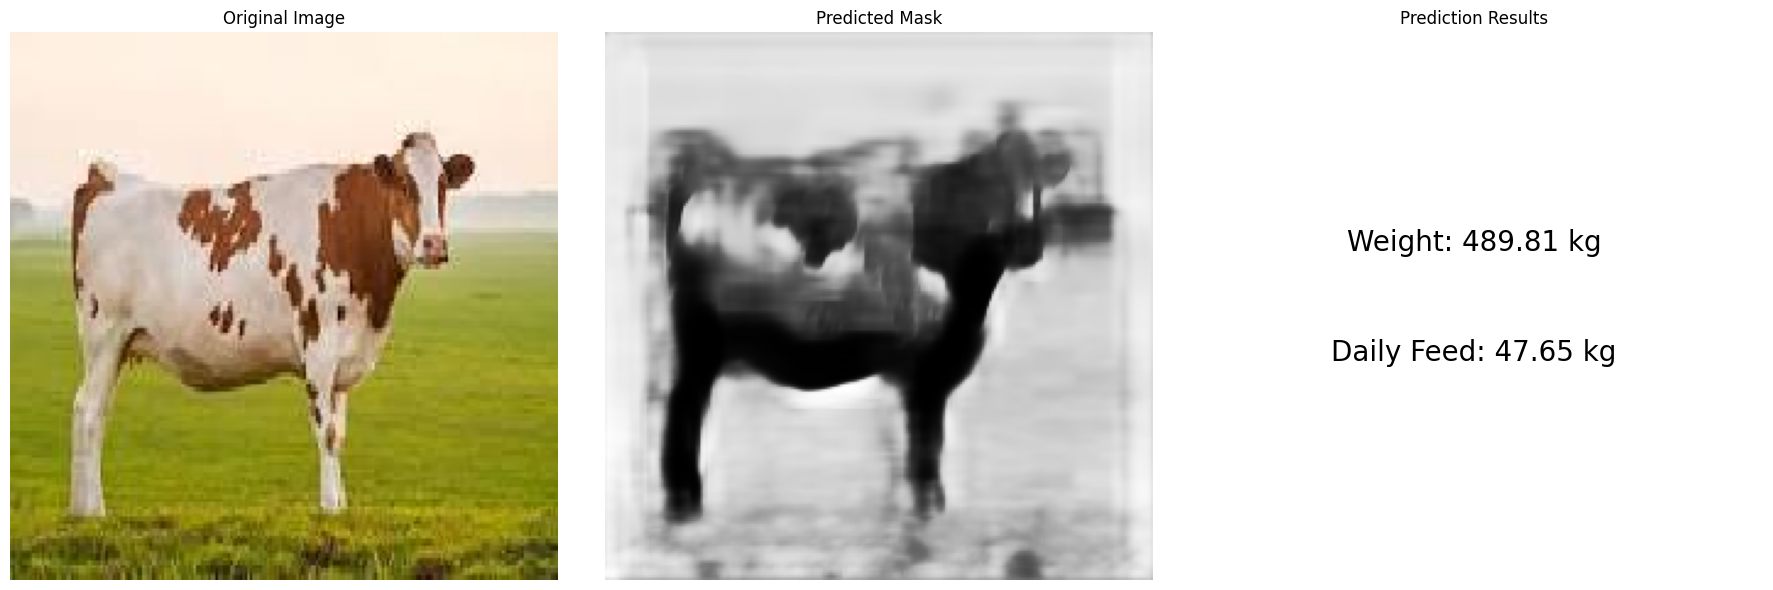

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from google.colab import drive, files
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd
import os


print("Mounting Google Drive...")
drive.mount('/content/drive')


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

DRIVE_PATH = "/content/drive/My Drive/cowproject2/weight"
SEG_MODEL_PATH = os.path.join(DRIVE_PATH, "best_seg_model.h5")
REG_MODEL_PATH = os.path.join(DRIVE_PATH, "best_reg_model.h5")

print("Loading segmentation model...")
seg_model = load_model(SEG_MODEL_PATH, custom_objects={'dice_coef': dice_coef})

print("Loading regression (weight) model...")
reg_model = load_model(REG_MODEL_PATH, compile=False)

print("Models loaded successfully.")

FEED_MODEL_PATH = "/content/drive/MyDrive/cowproject2/cow_feed_predictor.pkl"
print("Loading Feed Prediction Model...")
feed_model = joblib.load(FEED_MODEL_PATH)

# Load encoders
BREED_ENCODER = "/content/drive/MyDrive/cowproject2/weight/breed_encoder.pkl"
ACTIVITY_ENCODER = "/content/drive/MyDrive/cowproject2/weight/activity_encoder.pkl"

le_breed = joblib.load(BREED_ENCODER)
le_activity = joblib.load(ACTIVITY_ENCODER)

print("Feed model + encoders loaded.")

print("\nUpload a cow image:")
uploaded = files.upload()
filename = next(iter(uploaded))
print("Uploaded:", filename)

IMG_SIZE = (224, 224)

def process_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    return img_batch

input_image = process_image(filename)

print("Predicting mask...")
predicted_mask = seg_model.predict(input_image)

print("Predicting weight...")
predicted_weight = reg_model.predict(predicted_mask)
cow_weight = float(predicted_weight[0][0]*3)

print(f"Cow Weight Predicted = {cow_weight:.2f} kg")
cow_breed = "Sahiwal"
cow_age = 24
milk_yield = 12
activity = "Medium"

encoded_breed = le_breed.transform([cow_breed])[0]
encoded_activity = le_activity.transform([activity])[0]

feed_input = pd.DataFrame([{
    "Cow Breed": encoded_breed,
    "Cow Age (months)": cow_age,
    "Cow Weight (kg)": cow_weight,
    "Milk Yield (L/day)": milk_yield,
    "Activity Level": encoded_activity
}])

predicted_feed = feed_model.predict(feed_input)[0]
print(f"Daily Feed Prediction = {predicted_feed:.2f} kg")

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(input_image[0])
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask[0, ..., 0], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.text(0.5, 0.6, f"Weight: {cow_weight:.2f} kg", fontsize=20, ha='center')
plt.text(0.5, 0.4, f"Daily Feed: {predicted_feed:.2f} kg", fontsize=20, ha='center')
plt.title("Prediction Results")
plt.axis("off")

plt.tight_layout()
plt.show()
